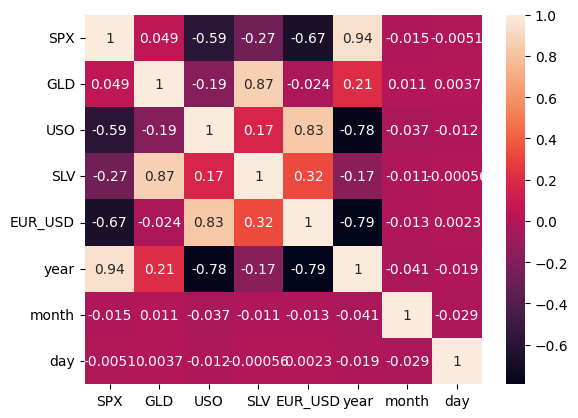


Model: LinearRegression
Train R2: 0.9023325757665657
Test  R2: 0.9127075876149024
Train MAE: 5.38333587553362
Test  MAE: 5.164098823996903
Train RMSE: 7.263135268245533
Test  RMSE: 6.918267167662617

Model: DecisionTreeRegressor
Train R2: 0.997997494487681
Test  R2: 0.9844898664413092
Train MAE: 0.6019134931051462
Test  MAE: 1.5324727026513159
Train RMSE: 1.0400066720801147
Test  RMSE: 2.9161969432793144

Model: RandomForestRegressor
Train R2: 0.9990777667011627
Test  R2: 0.9925084181955713
Train MAE: 0.4809486054097916
Test  MAE: 1.2137091244651848
Train RMSE: 0.7057805160166659
Test  RMSE: 2.0267297604119583


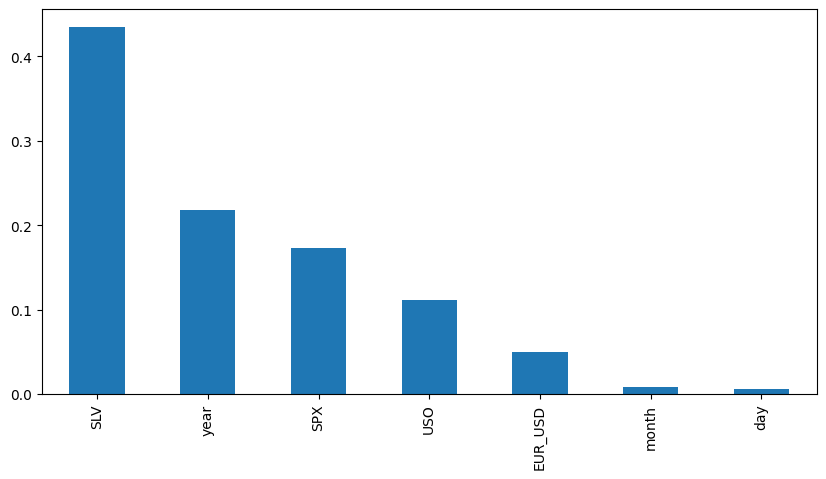


✅ Model and scaler saved successfully


In [216]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


df = pd.read_csv("Gold Loan .csv")

df.drop_duplicates(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')


df.rename(columns={'EUR/USD': 'EUR_USD'}, inplace=True)


df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)


sns.heatmap(df.corr(), annot=True)
plt.show()


X = df.drop('GLD', axis=1)
y = df['GLD']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def evaluate(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    print(f"\nModel: {model.__class__.__name__}")
    print("Train R2:", r2_score(y_train, train_pred))
    print("Test  R2:", r2_score(y_test, test_pred))
    print("Train MAE:", mean_absolute_error(y_train, train_pred))
    print("Test  MAE:", mean_absolute_error(y_test, test_pred))
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
    print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
evaluate(lr, X_train_scaled, X_test_scaled, y_train, y_test)


dtr = DecisionTreeRegressor(random_state=42)

dt_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

dt_search = GridSearchCV(
    dtr,
    dt_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

dt_search.fit(X_train, y_train)
best_dt = dt_search.best_estimator_

evaluate(best_dt, X_train, X_test, y_train, y_test)


rfr = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10, 15],
    'max_features': ['sqrt', 'log2']
}

rf_search = GridSearchCV(
    rfr,
    rf_params,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

evaluate(best_rf, X_train, X_test, y_train, y_test)


feat_imp = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feat_imp.plot(kind='bar', figsize=(10,5))
plt.show()


with open('gold_rf_model.pkl', 'wb') as f:
    pk.dump(best_rf, f)

with open('scaler.pkl', 'wb') as f:
    pk.dump(scaler, f)

feature_names = X.columns.tolist()

import pickle
with open("features.pkl", "wb") as f:
    pickle.dump(feature_names, f)



print("\n✅ Model and scaler saved successfully")
